In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from scipy.io import savemat

In [78]:
df = pd.read_csv('hybrid_manufacturing_categorical.csv')

df.head()

,Job_ID,Machine_ID,Operation_Type,Material_Used,Processing_Time,Energy_Consumption,Machine_Availability,Scheduled_Start,Scheduled_End,Actual_Start,Actual_End,Job_Status,Optimization_Category
0,J001,M01,Grinding,3.17,76,11.42,96,2023-03-18 08:00:00,2023-03-18 09:16:00,2023-03-18 08:05:00,2023-03-18 09:21:00,Completed,Moderate Efficiency
1,J002,M01,Grinding,3.35,79,6.61,84,2023-03-18 08:10:00,2023-03-18 09:29:00,2023-03-18 08:20:00,2023-03-18 09:39:00,Delayed,Low Efficiency
2,J003,M04,Additive,2.29,56,11.11,92,2023-03-18 08:20:00,2023-03-18 09:16:00,NaN,NaN,Failed,Low Efficiency
3,J004,M04,Grinding,1.76,106,12.50,95,2023-03-18 08:30:00,2023-03-18 10:16:00,2023-03-18 08:35:00,2023-03-18 10:21:00,Completed,Moderate Efficiency
4,J005,M01,Lathe,1.90,46,8.13,88,2023-03-18 08:40:00,2023-03-18 09:26:00,2023-03-18 08:42:00,2023-03-18 09:28:00,Completed,High Efficiency


In [79]:
df_filtrado = df[['Operation_Type', 'Material_Used', 'Processing_Time', 'Energy_Consumption']]
tipos = df['Operation_Type'].unique()
print("Tipos de operación:", tipos)

Tipos de operación: ['Grinding' 'Additive' 'Lathe' 'Milling' 'Drilling']


Calcular promedio según el tipo de operacion

In [80]:
promedios = df.groupby('Operation_Type')[['Processing_Time','Material_Used','Energy_Consumption']].mean()

print(promedios)

                Processing_Time  Material_Used  Energy_Consumption
Operation_Type                                                    
Additive              70.610526       3.144789            8.549737
Drilling              71.470899       3.025767            8.860741
Grinding              73.365385       2.962837            8.490625
Lathe                 71.169811       2.974858            8.478726
Milling               70.208955       3.035622            8.252090


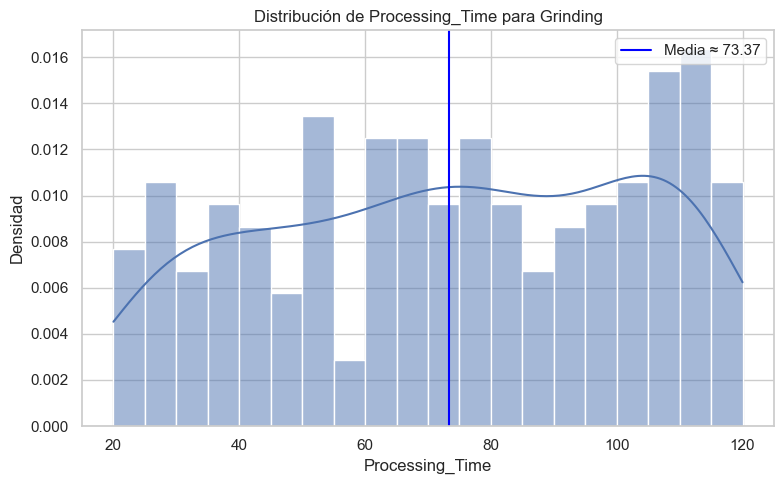

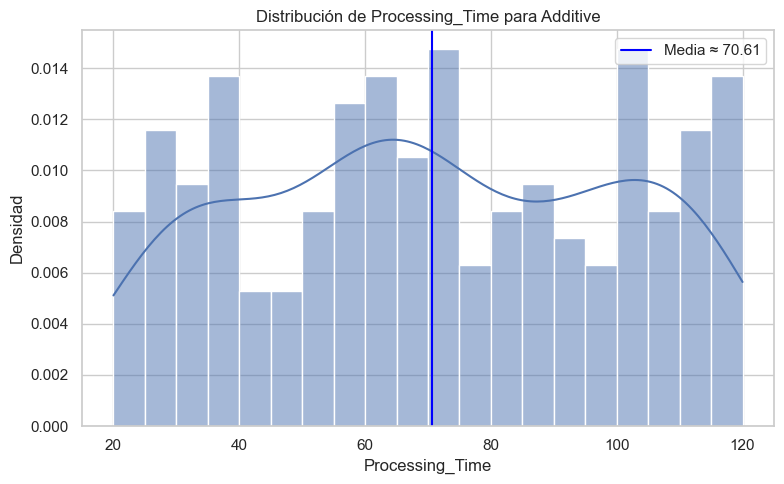

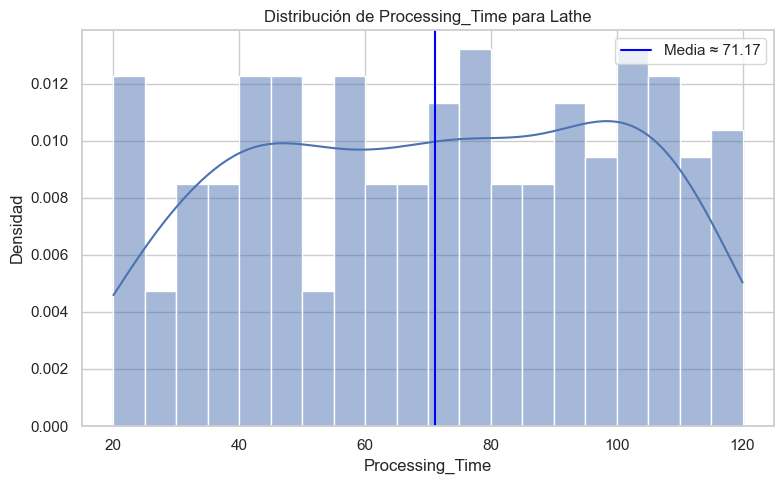

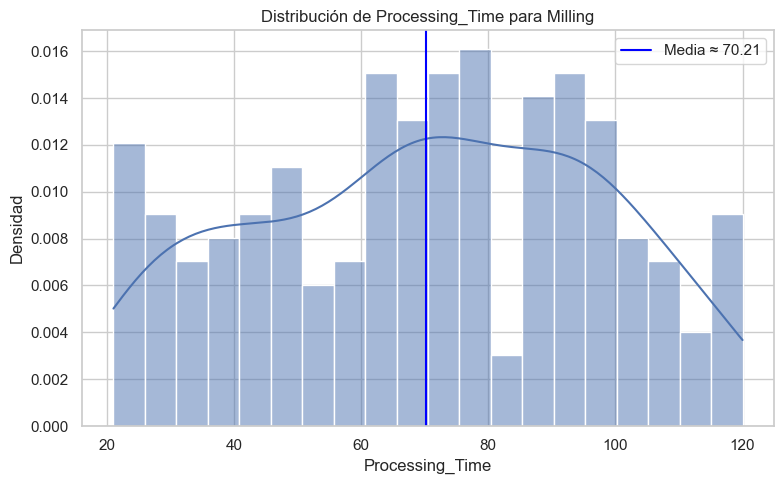

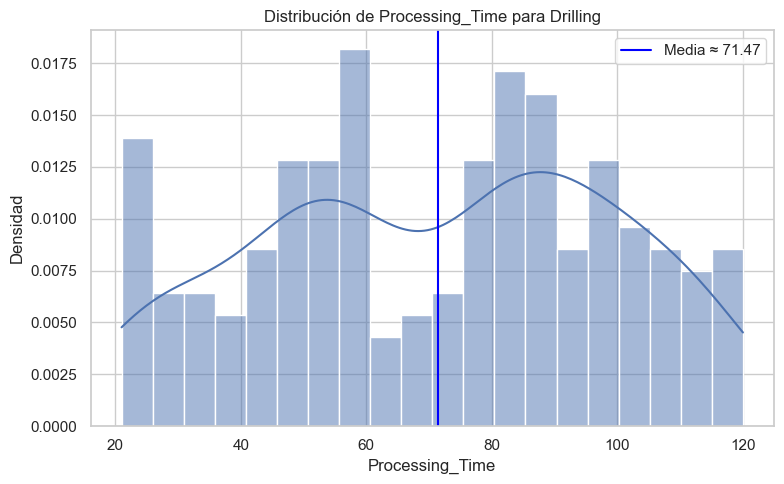

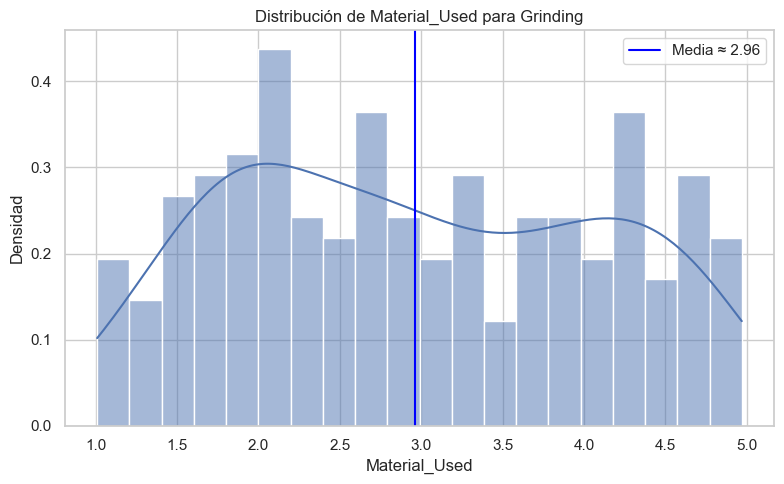

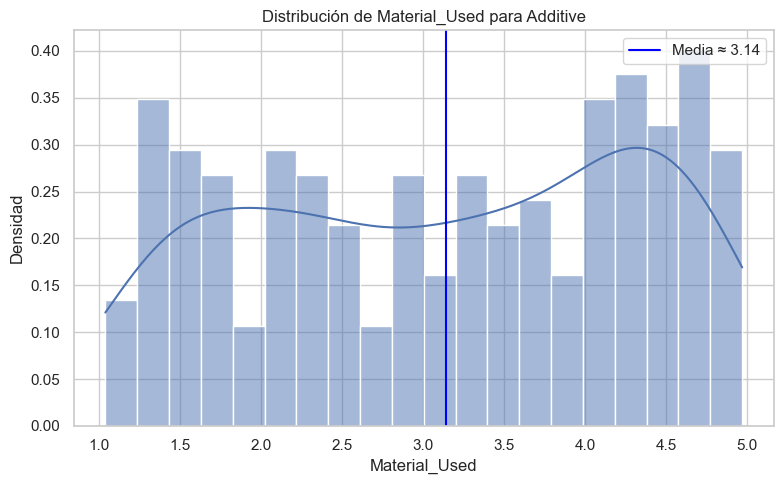

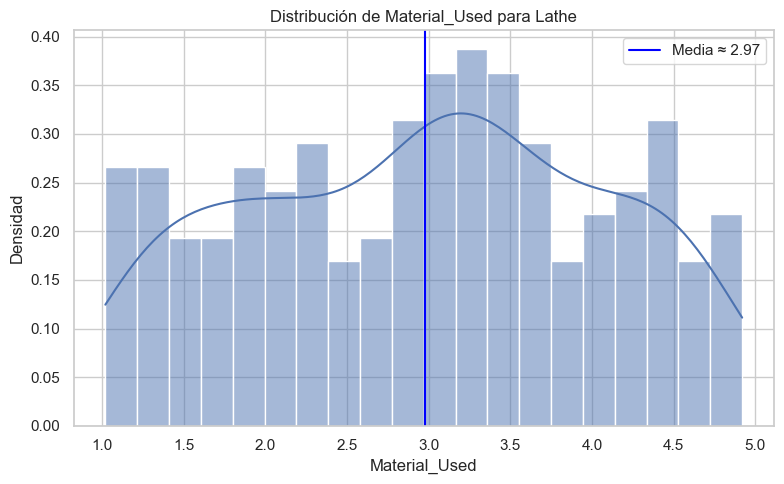

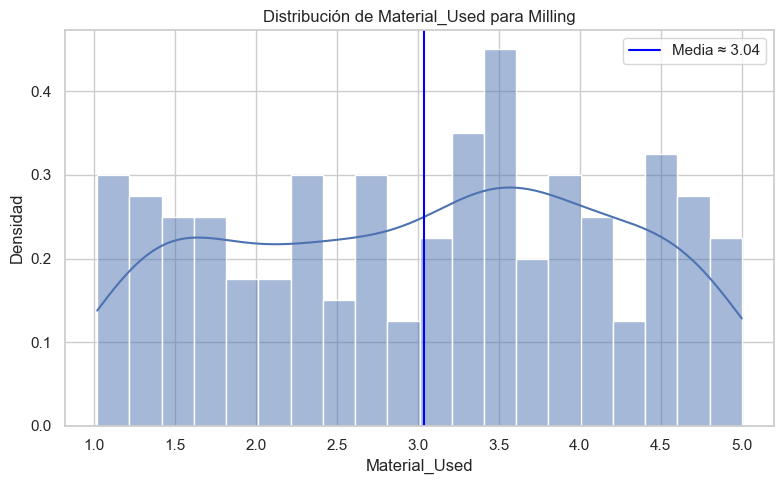

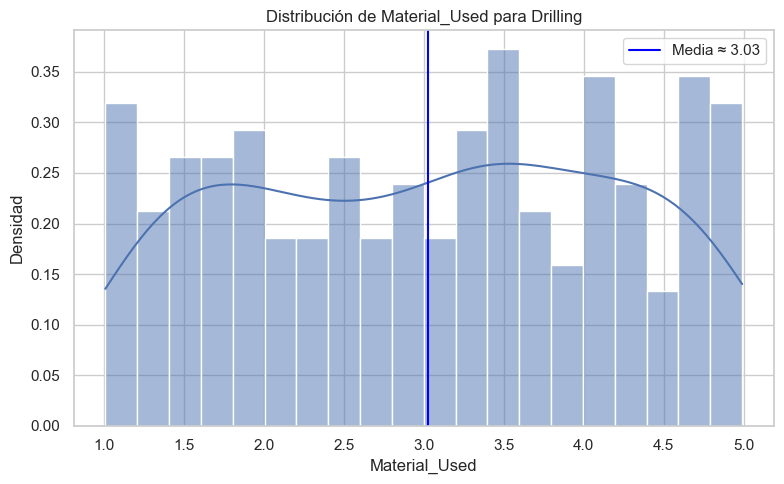

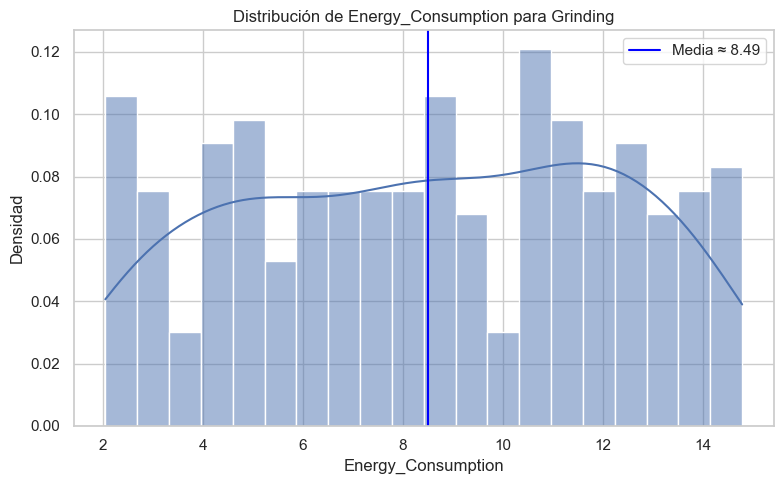

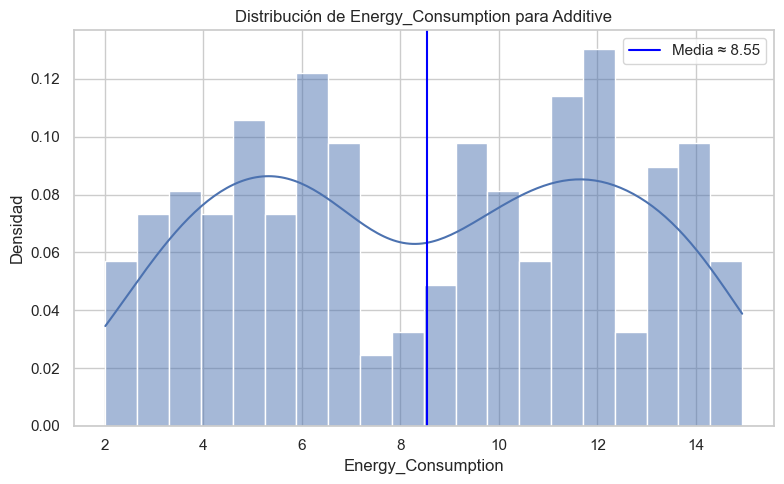

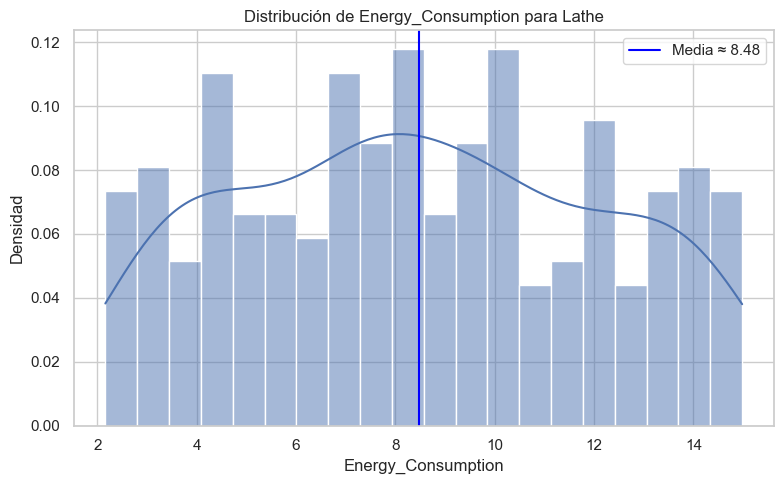

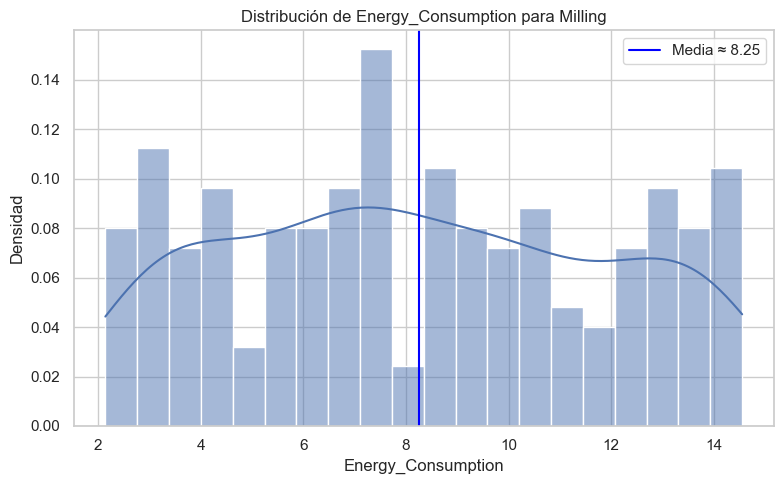

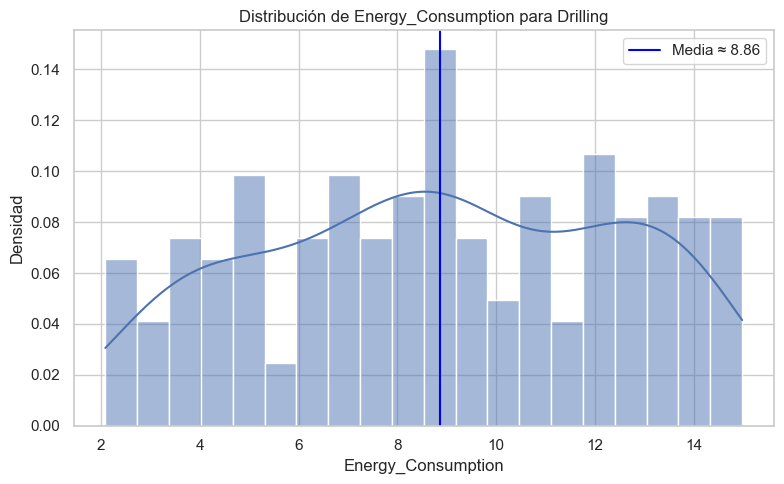

In [81]:
variables = ['Processing_Time', 'Material_Used', 'Energy_Consumption']
tipos_operacion = df['Operation_Type'].unique()

sns.set(style="whitegrid")

for var in variables:
    for op_type in tipos_operacion:
        subset = df[df['Operation_Type'] == op_type][var].dropna()

        plt.figure(figsize=(8, 5))
        sns.histplot(subset, kde=True, bins=20, stat='density')

        # Obtener la media desde el DataFrame promedios
        media = promedios.loc[op_type, var]

        plt.axvline(media, color='blue', linestyle='-', label=f'Media ≈ {media:.2f}')
        plt.title(f'Distribución de {var} para {op_type}')
        plt.xlabel(var)
        plt.ylabel('Densidad')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

#### Formar matriz A, A_hat y b para el espacio de incertidumbre fe la media

In [82]:
# Generar la matriz A 
tabla_A = promedios.T
A_media = tabla_A.values
print("Matriz A_media:")
print(A_media)
#----------------------------------------- o -----------------------------------------
# Generar la matriz A_hat
A_hat_media = np.array([
    [15, 10, 7, 9, 5],
    [0.5, 0.3, 0.7, 0.25, 0.1],
    [1, 1, 2, 1, 0.5]
])

print("Matriz A_hat:")
print(A_hat_media)

#----------------------------------------- o -----------------------------------------
# Generar la matriz b
b = np.array([480,120,135])
print("Matriz b:")
print(b)

Matriz A_media:
[[70.61052632 71.47089947 73.36538462 71.16981132 70.20895522]
 [ 3.14478947  3.0257672   2.96283654  2.97485849  3.03562189]
 [ 8.54973684  8.86074074  8.490625    8.47872642  8.25208955]]
Matriz A_hat:
[[15.   10.    7.    9.    5.  ]
 [ 0.5   0.3   0.7   0.25  0.1 ]
 [ 1.    1.    2.    1.    0.5 ]]
Matriz b:
[480 120 135]


Guardar datos

In [83]:
# Guardar todas las matrices en un único archivo .mat
savemat("Datos_Manufacturing_media.mat", {'A_media': A, 'A_hat_media': A_hat, 'b': b})

#### Formar matriz A, A_hat y b para el espacio de incertidumbre [min max]

In [84]:
# Calcular mínimo y máximo para cada variable por cada Operation_Type
minimos = df.groupby('Operation_Type')[variables].min()
maximos = df.groupby('Operation_Type')[variables].max()

# Combinar en una sola tabla con etiquetas claras
tabla_completa = pd.concat([minimos.add_suffix(' (mínimo)'), maximos.add_suffix(' (máximo')], axis=1)

tabla_completa.head()

,Processing_Time (mínimo),Material_Used (mínimo),Energy_Consumption (mínimo),Processing_Time (máximo,Material_Used (máximo,Energy_Consumption (máximo
Operation_Type,,,,,,
Additive,20,1.04,2.01,120,4.97,14.94
Drilling,21,1.01,2.09,120,4.99,14.98
Grinding,20,1.01,2.05,120,4.97,14.78
Lathe,20,1.02,2.16,120,4.92,14.98
Milling,21,1.02,2.14,120,5.00,14.55


In [85]:
# Lista de intervalos [min, max] para cada a_ij, ordenados fila por fila
intervalos = [
    [20, 120], [21, 120], [20, 120], [20, 121], [21, 120],          # Fila 1 (Processing_Time)
    [1.04, 4.97], [1.01, 4.99], [1.01, 4.97], [1.02, 4.92], [1.02, 5.00],  # Fila 2 (Material_Used)
    [2.01, 14.94], [2.09, 14.98], [2.05, 14.78], [2.16, 14.98], [2.14, 14.55]  # Fila 3 (Energy_Consumption)
]

# Calcular la desviación como la mitad del ancho del intervalo
desviaciones = [(max_val - min_val) / 2 for min_val, max_val in intervalos]

# Calcular el valor central (media del intervalo)
valores_centrales = [(min_val + max_val) / 2 for min_val, max_val in intervalos]



# Convertir las listas a array NumPy con forma 3x5

A_MinMax = np.array(valores_centrales).reshape(3, 5)

A_hat_MinMax = np.array(desviaciones).reshape(3, 5)

Guardar datos

In [86]:
# Guardar todas las matrices en un único archivo .mat
savemat("Datos_Manufacturing_MinMax.mat", {'A_MinMax': A_MinMax, 'A_hat_MinMax': A_hat_MinMax, 'b': b})